In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
import os 
import threading
import seaborn as sns; sns.set()
%matplotlib inline

#### Time setting

In [2]:
os.environ['TZ'] = 'UTC'   # fix timezone 
try:
    time.tzset()
except:
    pass
    
def get_time(tstamp):
    """
    Convert timestamp to str of time 
    """
    return time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(tstamp/1000))
v_get_time = np.vectorize(get_time)   # vectorize the fct 

def get_timestamp(dt):
    """
    Convert struct_time to timestamp 
    
    dt: str
    """
    return time.mktime(time.strptime(dt, "%Y-%m-%d %H:%M:%S"))
v_get_timestamp = np.vectorize(get_timestamp)

#### Maximum circular sum problem

In [3]:
### ref: https://www.geeksforgeeks.org/maximum-contiguous-circular-sum/

# Standard Kadane's algorithm to find maximum subarray sum 
def kadane(a): 
    n = len(a) 
    max_so_far = 0
    max_ending_here = 0
    ind = [0, 0]
    ind_min = 0 
    for i in range(0, n): 
        max_ending_here = max_ending_here + a[i] 
        if (max_ending_here <= 0): 
            max_ending_here = 0
            ind_min = i+1   # restart the sum from the next index 
        if (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
            ind[1] = i   # update the end index that provides the maximal sum 
            ind[0] = ind_min 
    return max_so_far, ind 

def maxCircularSum(a_): 
    a = a_.copy()
    n = len(a) 
  
    # Case 1: get the maximum sum using standard kadane's 
    # algorithm 
    max_kadane_1, ind_1 = kadane(a) 
   
    # Case 2: Now find the maximum sum that includes corner 
    # elements. 
    max_wrap = 0
    for i in range(0,n): 
        max_wrap += a[i] 
        a[i] = -a[i] 
  
    # Max sum with corner elements will be: 
    # array-sum - (-max subarray sum of inverted array) 
    max_kadane_2, ind_2 = kadane(a) 
    max_wrap = max_wrap + max_kadane_2
  
    # The maximum circular sum will be maximum of two sums 
    if max_wrap > max_kadane_1: 
        return max_wrap, [ind_2[-1]+1, ind_2[0]-1] 
    else: 
        return max_kadane_1, ind_1 
    
    
def minCircularSum(a):
    """
    Find minimum circular sum (minimum is maximum of negative)
    """
    rtn, ind = maxCircularSum(-np.array(a))
    return -rtn, ind 
    

In [4]:
a=np.array([-1, 1, 3,-1, -9,  11])
print(maxCircularSum(a))
print(minCircularSum(a))

(14, [5, 2])
(-10, [3, 4])


In [5]:
def agg_CircularSum(df_by):
    
    ts = [i[1] for i in df_by.iloc[0].index]
 
    seq = np.arange(len(ts))
    DF_max = pd.DataFrame(0, columns = df_by.index, index = ts)
    DF_min = pd.DataFrame(0, columns = df_by.index, index = ts)
    Rtn_max = pd.Series(0, index = df_by.index)
    Rtn_min = pd.Series(0, index = df_by.index)
    for y in df_by.index:
        if np.sum(df_by.loc[y].Return!=0) == 0:
            continue
            
        rtn, ind = maxCircularSum(df_by.loc[y])   # max 
        if ind[0] <= ind[1]:
            in_ = np.logical_and(seq>=ind[0], seq<=ind[1])
        elif ind[0] > ind[1]:   # this means midnight 
            in_ = np.logical_or(seq>=ind[0], seq<=ind[1])
        DF_max.loc[in_, y] = 1
        Rtn_max.loc[y] = rtn
    
        
        rtn, ind = minCircularSum(df_by.loc[y])   # min 
        if ind[0] <= ind[1]:
            in_ = np.logical_and(seq>=ind[0], seq<=ind[1])
        elif ind[0] > ind[1]:   # this means midnight 
            in_ = np.logical_or(seq>=ind[0], seq<=ind[1])
        DF_min.loc[in_, y] = 1
        Rtn_min.loc[y] = rtn
        
    return DF_max, Rtn_max, DF_min, Rtn_min

#### Aggregate 1-min data to a specified interval

In [6]:
def agg_data(DF, freq = 'h'):
    df = DF.copy()
    df.index = v_get_time(df.index)
    df['Date'] = df.index.map(lambda x: x.split()[0])
    
    df['Time'] = pd.to_datetime(df.index)
    
    
    df.reset_index(drop=True, inplace=True)
    
    df_by = df[['Return', 'Date', 'Time']].groupby(['Date', pd.Grouper(key='Time', freq=freq)]).apply(np.sum).drop(['Date'], axis=1)
    
    df_by = df_by.fillna(0)
    
    df_by.index.set_levels(df_by.index.levels[1].map(lambda x: x.strftime('%Y-%m-%d %h:%m:%s')), level=1, inplace=True)
        
    return df_by

In [7]:
# a = agg_data(df_[0], freq='4h')
# a

#### Search for highest / lowest intraday return

In [8]:
def get_extreme_return(df, by = 'Month'):
    
    df_by = df.copy()
    df_by.index = df_by.index.map(' '.join)
    
    if by == 'Month':
        df_by[by] = df_by.index.map(lambda x: ''.join(x.split('-')[:2]))
    elif by == 'Year': 
        df_by[by] = df_by.index.map(lambda x: x.split('-')[0])
    
    df_by['Time'] = df_by.index.map(lambda x: x.split()[-1])   # the Hour   
    
    df_by.reset_index(drop=True, inplace=True)

    
    df_by = df_by[['Return', by, 'Time']].groupby([by, 'Time']).apply(np.mean)
    try:
        df_by = df_by.drop([by], axis=1).unstack()
    except:
        df_by = df_by.unstack()
    

    return agg_CircularSum(df_by)

In [9]:
def get_extreme_vol(df, by = 'Month'):
    
    df_by = df.copy()
    df_by.index = df_by.index.map(' '.join)
    
    if by == 'Month':
        df_by[by] = df_by.index.map(lambda x: ''.join(x.split('-')[:2]))
    elif by == 'Year': 
        df_by[by] = df_by.index.map(lambda x: x.split('-')[0])
    
    df_by['Time'] = df_by.index.map(lambda x: x.split()[-1])   # the Hour   
    
    df_by.reset_index(drop=True, inplace=True)

    
    df_by = df_by[['Return', by, 'Time']].groupby([by, 'Time']).apply(np.mean)
  
    try:
        df_by = df_by.drop([by], axis=1).unstack()
    except:
        df_by = df_by.unstack()
    
    
    df_by = df_by.sub(df_by.mean(axis=1), axis=0)
    

    return agg_CircularSum(df_by)

#### Experiments

In [10]:
### load dataset 

path = os.path.join(os.getcwd(), 'data')   # pls put the sript together with the "data" folder  
fns = os.listdir(path)[1:]
df_ = []

length = 60*1000   # 1 min
for fn in fns:
    with open(os.path.join(path, fn), 'r') as f:
        df = pd.read_csv(f)
        df.drop_duplicates(subset=['UTC','Close'], inplace=True)
        df.set_index('UTC', inplace=True)
        df.sort_index(inplace = True)
        
        ts = np.arange(df.index.min(), df.index.max(), length)
        df = df.reindex(ts).fillna(method='ffill')
        df['Return'] = np.log(df.Close.pct_change()+1)
        df_.append(df)
        
for i in range(len(df_)):
    temp_df = df_[i].copy()
    print(get_time(temp_df.index.min()), get_time(temp_df.index.max()))

2018-11-13 03:25:00 2020-07-07 18:52:00
2013-03-31 16:07:00 2020-07-05 17:28:00
2016-03-09 08:04:00 2020-07-04 08:14:00
2018-11-27 07:00:00 2020-07-05 06:57:00
2017-05-19 09:57:00 2020-07-07 03:34:00
2015-09-25 04:34:00 2020-07-02 12:38:00
2018-08-02 01:06:00 2020-07-02 17:44:00
2020-02-04 20:00:00 2020-07-02 10:38:00


#### *Return Pattern*

In [11]:
freq = '4h'

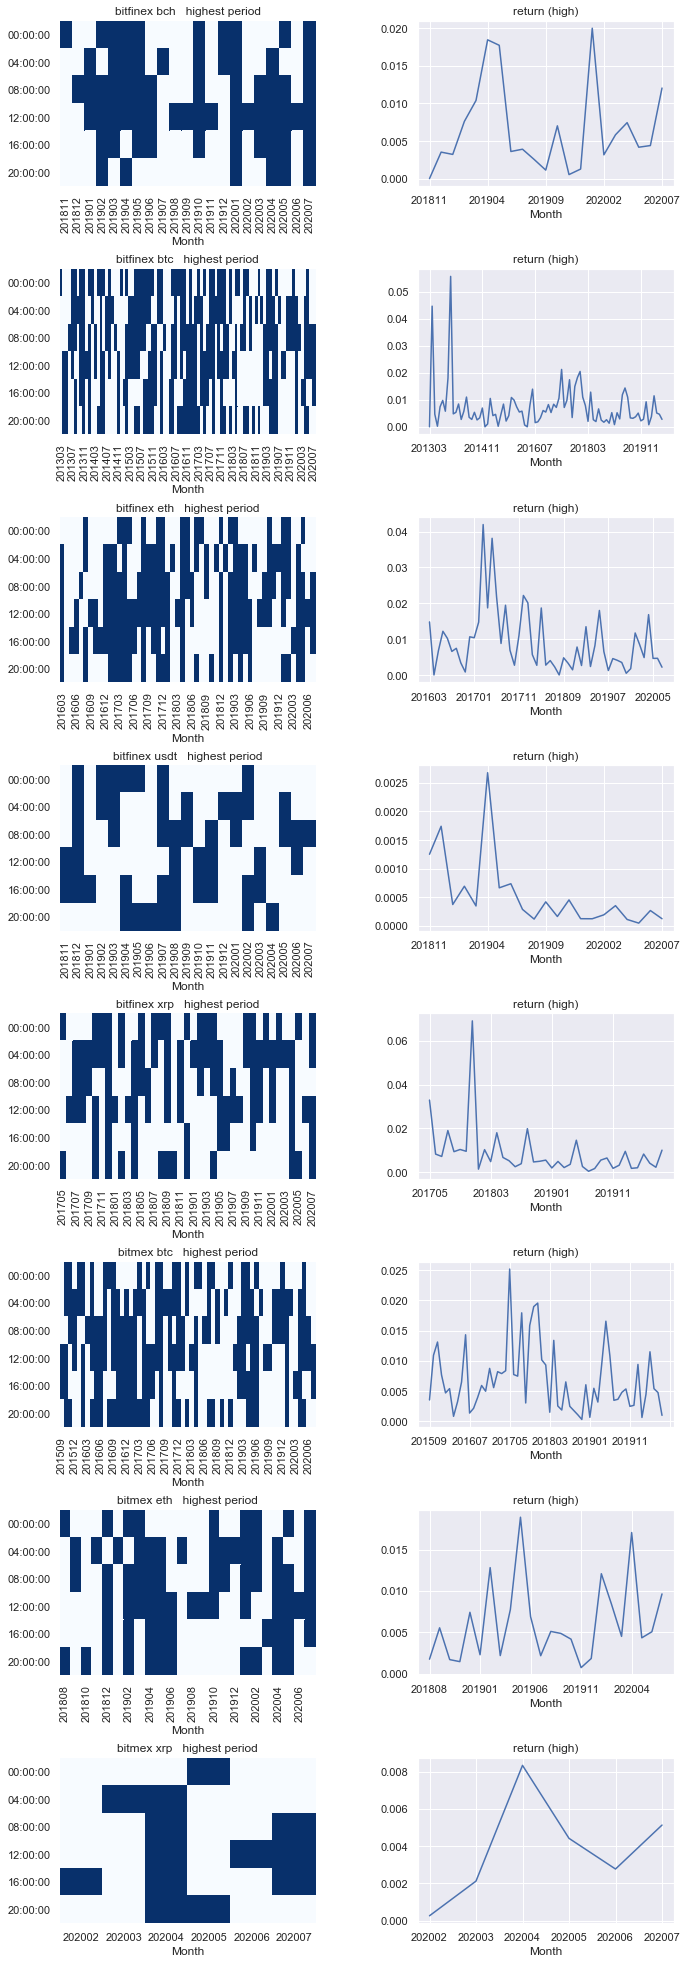

In [12]:
# 
DF_max = []; DF_min = []
Rtn_max = []; Rtn_min = []

for i in range(len(df_)):   
    res = get_extreme_return(agg_data(df_[i], freq = freq))
    DF_max.append(res[0])
    Rtn_max.append(res[1])
    DF_min.append(res[2])
    Rtn_min.append(res[3])
    
DF_ = DF_max; Rtn_ = Rtn_max; flag = '(high)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
f = lambda x: ' '.join(x.split('_')[:-1])
for i in range(len(axs)):
#     for j in range(len(axs[0])):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(f(fns[i])+'   highest period')
        ax[1].set_title('return '+flag)

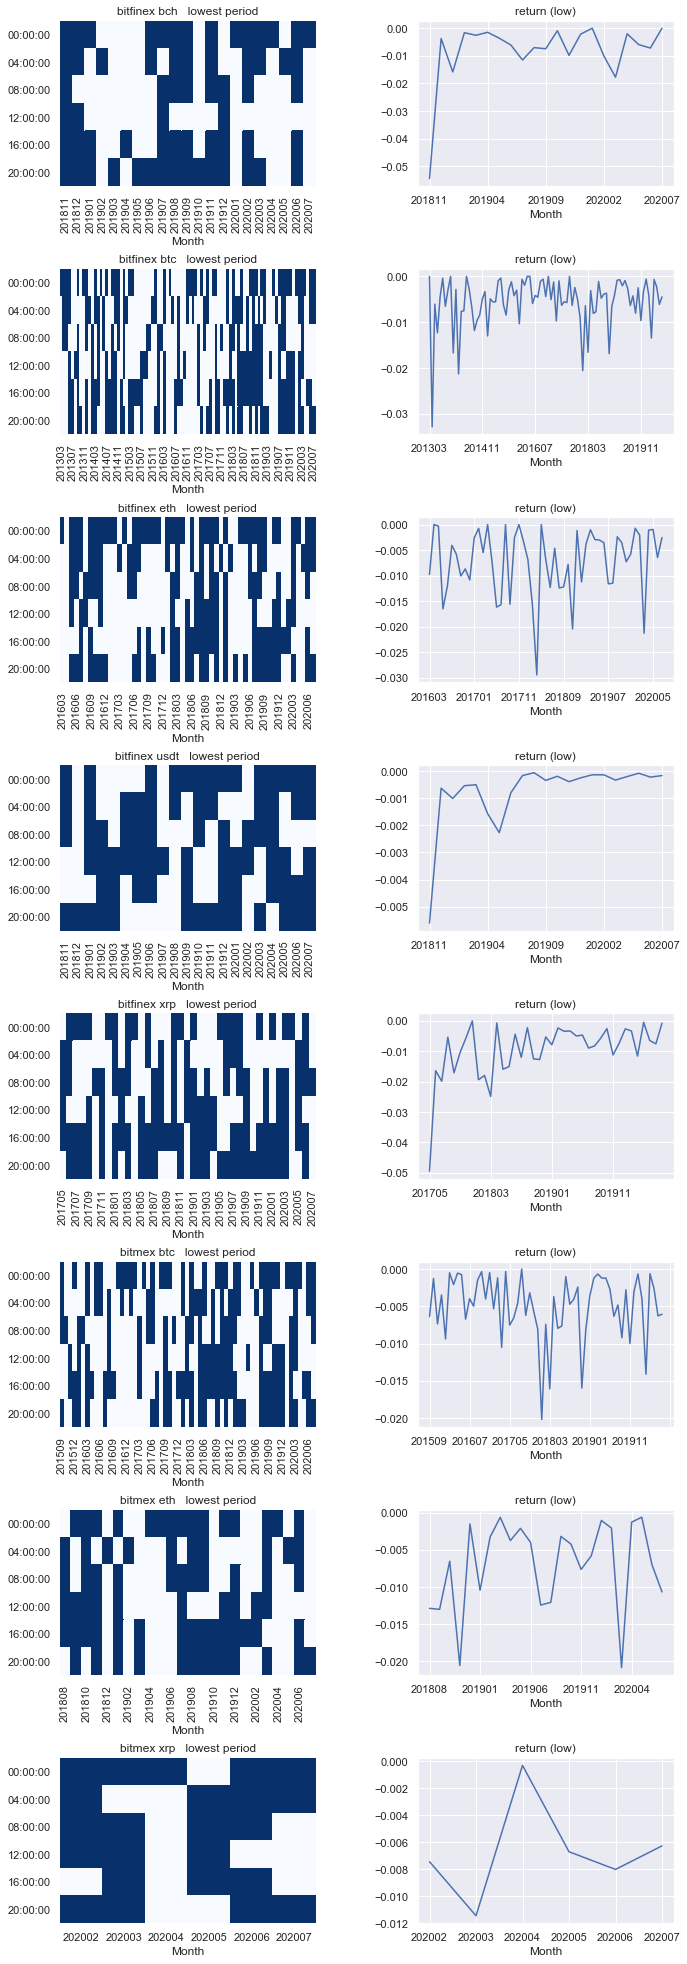

In [13]:
DF_ = DF_min; Rtn_ = Rtn_min; flag = '(low)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
f = lambda x: ' '.join(x.split('_')[:-1])
for i in range(len(axs)):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(f(fns[i])+'   lowest period')
        ax[1].set_title('return '+flag)

#### *Volatility Pattern*

In [14]:
freq = '4h'

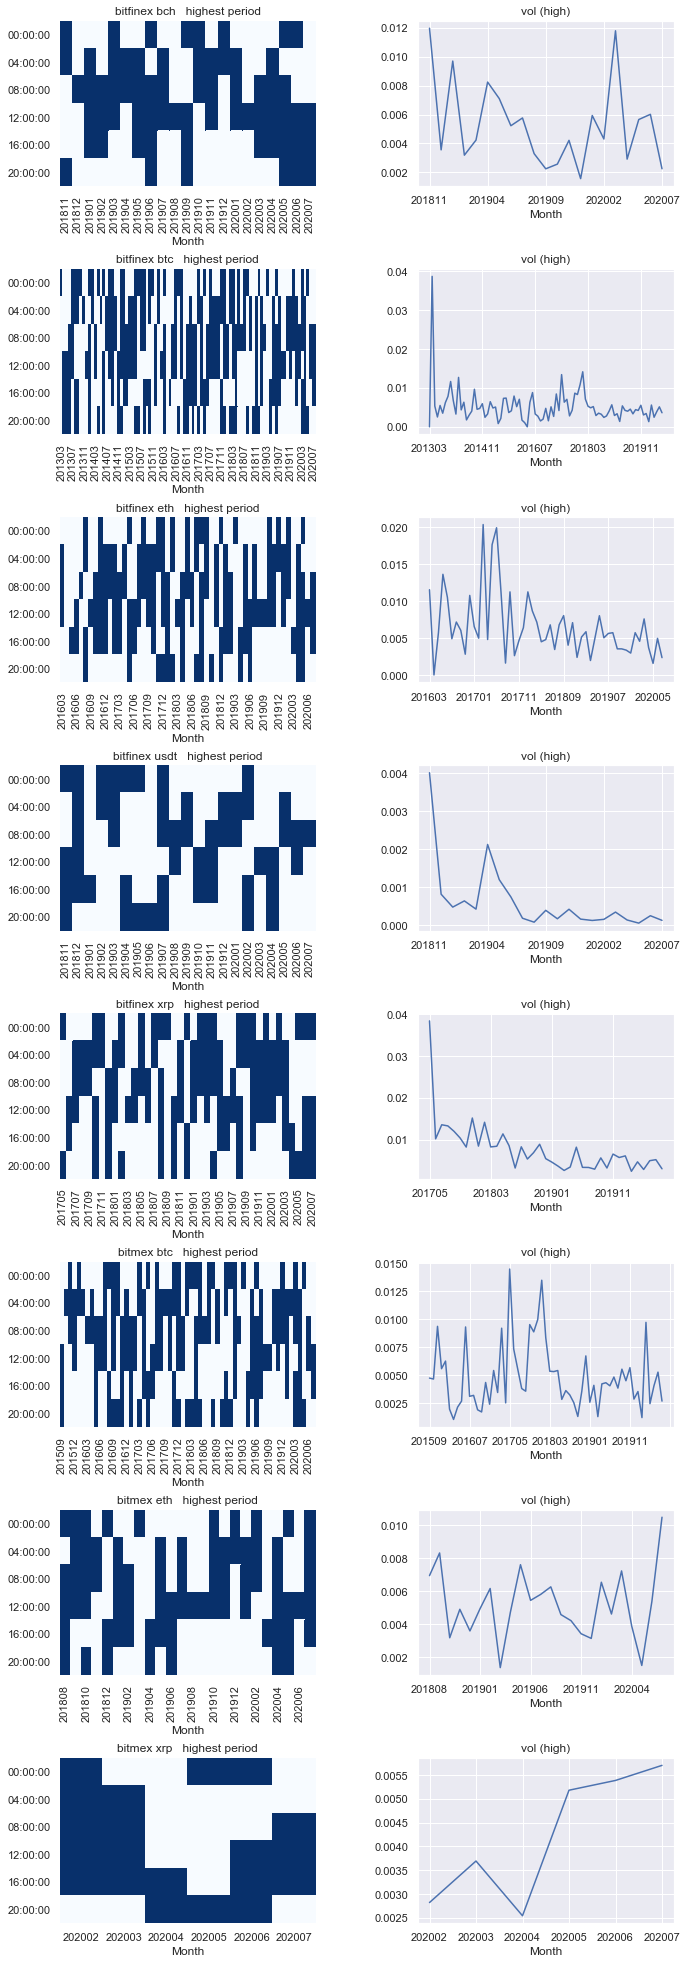

In [15]:
# 
DF_max = []; DF_min = []
Rtn_max = []; Rtn_min = []

for i in range(len(df_)):   
    res = get_extreme_vol(agg_data(df_[i], freq = freq))
    DF_max.append(res[0])
    Rtn_max.append(res[1])
    DF_min.append(res[2])
    Rtn_min.append(res[3])
    
DF_ = DF_max; Rtn_ = Rtn_max; flag = '(high)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
f = lambda x: ' '.join(x.split('_')[:-1])
for i in range(len(axs)):
#     for j in range(len(axs[0])):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(f(fns[i])+'   highest period')
        ax[1].set_title('vol '+flag)

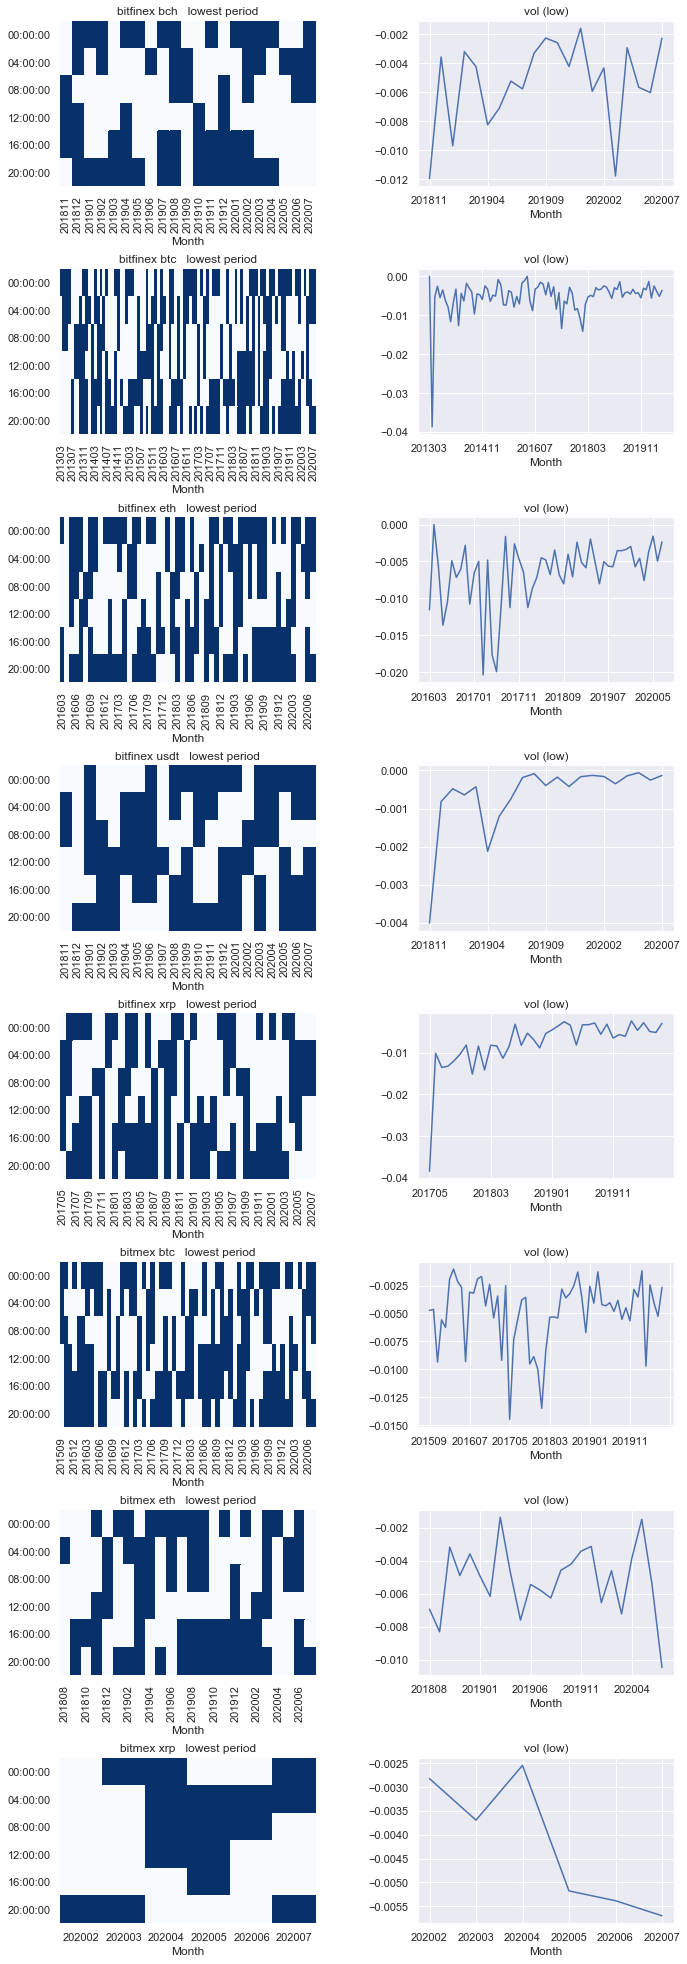

In [16]:
DF_ = DF_min; Rtn_ = Rtn_min; flag = '(low)'

fig, axs = plt.subplots(8,2, figsize=(11, 35))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
f = lambda x: ' '.join(x.split('_')[:-1])
for i in range(len(axs)):
        ax = axs[i]
        sns.heatmap(DF_[i], cmap="Blues", cbar=False, ax=ax[0])
        Rtn_[i].plot(ax=ax[1])
        ax[0].set_title(f(fns[i])+'   lowest period')
        ax[1].set_title('vol '+flag)